# Stock movement prediction: Baseline vs. LSTM

## Objective
Predict if tomorrow's closing price will be higher than today's (Up=1, Down=0) using the last 30 days of data.

## Approach
1. Exploratory Data Analysis (EDA)
2. Feature engineering (lags and simple indicators)
3. Baseline models: Logistic Regression, Random Forest
4. Advanced model: LSTM
5. Evaluation: Accuracy, Precision, Recall, Confusion matrix
6. Documentation and GitHub publishing

## Notes
- Time-ordered splits to avoid leakage
- Feature scaling only fitted on training data
- Models compared on the same test window


# Data and environment setup

In [3]:
# 0. Imports and basic setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# For LSTM
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping

## 1. Load Data

In [ ]:
DATA_PATH = "../data/financial_forecasting_dataset.csv"
RESULTS_PATH = "../results"

df = pd.read_csv(DATA_PATH)
df

,Date,Ticker,Open,High,Low,Close,Volume,GDP (%),Inflation (%),Interest Rate (%),Unemployment (%),Market Stress Level,Event Flag
0,2020-01-01,AAPL,215.19,215.61,213.25,213.62,13046059,2.14,2.30,1.35,3.58,0.26,0
1,2020-01-02,AAPL,216.79,221.37,215.51,217.65,8515186,2.73,1.93,1.52,2.86,0.18,0
2,2020-01-03,AAPL,209.71,210.58,207.90,208.23,13704556,1.73,2.00,1.44,4.31,0.06,0
3,2020-01-04,AAPL,213.80,216.45,210.78,212.32,6833411,1.77,2.32,1.59,2.59,0.35,0
4,2020-01-05,AAPL,209.33,211.16,206.23,210.03,11862560,1.90,1.81,1.12,4.88,0.27,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,2021-05-10,TSLA,350.28,355.76,349.19,351.00,11258842,2.00,2.43,1.71,3.72,0.34,0
1496,2021-05-11,TSLA,352.02,358.32,345.71,355.93,11074730,2.34,1.81,1.45,5.07,0.12,0
1497,2021-05-12,TSLA,353.19,356.72,352.79,354.60,11250956,2.03,2.03,1.49,2.73,0.32,0
1498,2021-05-13,TSLA,344.95,345.73,344.86,345.44,9059909,2.16,1.45,1.44,5.85,0.15,0


## 2. Basic Cleaning

In [5]:
df['Date'] = pd.to_datetime(df['Date']) 
df = df.sort_values('Date') 
df = df.reset_index(drop=True)

# If multiple tickers are present, filter to one for clarity 
if 'Ticker' in df.columns: 
    df = df[df['Ticker'] == 'AAPL'].copy()

print(df.columns) 
df.head()

Index(['Date', 'Ticker', 'Open', 'High', 'Low', 'Close', 'Volume', 'GDP (%)',
       'Inflation (%)', 'Interest Rate (%)', 'Unemployment (%)',
       'Market Stress Level', 'Event Flag'],
      dtype='object')


,Date,Ticker,Open,High,Low,Close,Volume,GDP (%),Inflation (%),Interest Rate (%),Unemployment (%),Market Stress Level,Event Flag
0,2020-01-01,AAPL,215.19,215.61,213.25,213.62,13046059,2.14,2.30,1.35,3.58,0.26,0
3,2020-01-02,AAPL,216.79,221.37,215.51,217.65,8515186,2.73,1.93,1.52,2.86,0.18,0
6,2020-01-03,AAPL,209.71,210.58,207.90,208.23,13704556,1.73,2.00,1.44,4.31,0.06,0
9,2020-01-04,AAPL,213.80,216.45,210.78,212.32,6833411,1.77,2.32,1.59,2.59,0.35,0
14,2020-01-05,AAPL,209.33,211.16,206.23,210.03,11862560,1.90,1.81,1.12,4.88,0.27,0


# EDA and feature engineering

> **Goal**: Understand the series and build simple, robust features that a baseline model can learn from, and that an LSTM can consume as sequences.

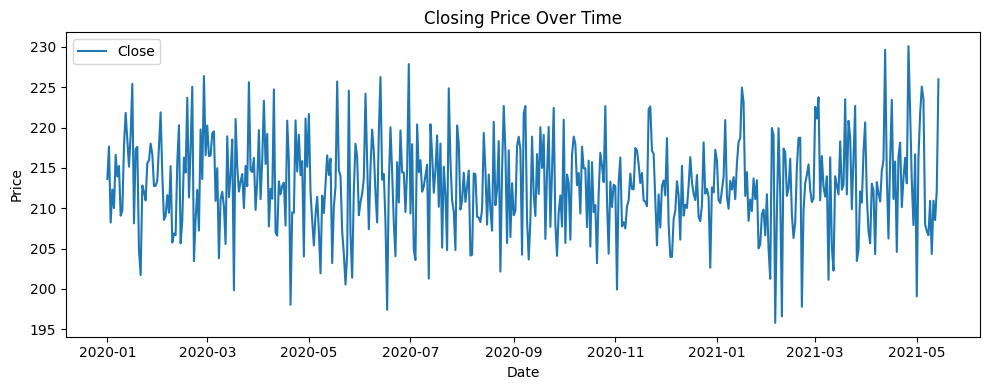

Missing values:
 Date                   0
Ticker                 0
Open                   0
High                   0
Low                    0
Close                  0
Volume                 0
GDP (%)                0
Inflation (%)          0
Interest Rate (%)      0
Unemployment (%)       0
Market Stress Level    0
Event Flag             0
dtype: int64


In [6]:
# EDA: quick plots
plt.figure(figsize=(10,4))
plt.plot(df['Date'], df['Close'], label='Close')
plt.title('Closing Price Over Time')
plt.xlabel('Date'); plt.ylabel('Price'); plt.legend(); plt.tight_layout()
plt.show()

# Missing values check
print("Missing values:\n", df.isna().sum())

# Create target: 1 if tomorrow's close > today's close, else 0
df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)

# Lag features: last 30 days of Close
for lag in range(1, 31):
    df[f'lag_{lag}'] = df['Close'].shift(lag)

# Simple technical features (optional, still simple)
# pct_change(): Calculates the percentage change from the previous value. Formula: (current - previous) / previous
# Measures the daily return or percentage change in the closing price.
df['return_1d'] = df['Close'].pct_change()

# rolling_mean_5: Calculates the rolling mean over the last 5 days. Formula: average of the last 5 values.
# Measures the moving average of the closing price, smoothing short-term fluctuations.
df['rolling_mean_5'] = df['Close'].rolling(5).mean()

# rolling_std_5: Calculates the rolling standard deviation over the last 5 days. Formula: sqrt(average of squared differences from mean)
# Measures the volatility or variability in the closing price over the past 5 days.
df['rolling_std_5'] = df['Close'].rolling(5).std()

# Drop rows with NaN from feature creation
df_model = df.dropna().copy()

# Final feature set for baseline
lag_cols = [f'lag_{i}' for i in range(1,31)]
feat_cols = lag_cols + ['return_1d', 'rolling_mean_5', 'rolling_std_5']
X = df_model[feat_cols].values
y = df_model['Target'].values

# Time-based train/test split (e.g., last 20% as test)
split_idx = int(len(df_model)*0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Baseline models
> **Why**: Fast, interpretable starting point, sets a realistic benchmark.
>
> **Key point**: Use StandardScaler for Logistic Regression. Random Forest doesn’t need scaling.

Logistic Regression — Acc: 0.648936170212766 Prec: 0.6829268292682927 Rec: 0.5833333333333334
              precision    recall  f1-score   support

           0       0.62      0.72      0.67        46
           1       0.68      0.58      0.63        48

    accuracy                           0.65        94
   macro avg       0.65      0.65      0.65        94
weighted avg       0.65      0.65      0.65        94

Random Forest — Acc: 0.6595744680851063 Prec: 0.6904761904761905 Rec: 0.6041666666666666
              precision    recall  f1-score   support

           0       0.63      0.72      0.67        46
           1       0.69      0.60      0.64        48

    accuracy                           0.66        94
   macro avg       0.66      0.66      0.66        94
weighted avg       0.66      0.66      0.66        94



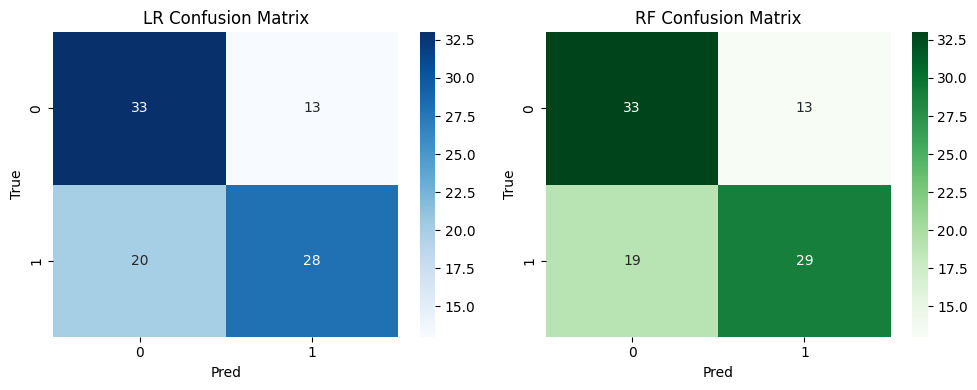

In [7]:
# 1) Logistic Regression (with scaling)
scaler = StandardScaler()
X_train_lr = scaler.fit_transform(X_train)
X_test_lr  = scaler.transform(X_test)

lr = LogisticRegression(max_iter=500)
lr.fit(X_train_lr, y_train)
lr_pred = lr.predict(X_test_lr)

lr_acc = accuracy_score(y_test, lr_pred)
lr_prec = precision_score(y_test, lr_pred)
lr_rec = recall_score(y_test, lr_pred)
print("Logistic Regression — Acc:", lr_acc, "Prec:", lr_prec, "Rec:", lr_rec)
print(classification_report(y_test, lr_pred))

# 2) Random Forest
rf = RandomForestClassifier(n_estimators=300, max_depth=None, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

rf_acc = accuracy_score(y_test, rf_pred)
rf_prec = precision_score(y_test, rf_pred)
rf_rec = recall_score(y_test, rf_pred)
print("Random Forest — Acc:", rf_acc, "Prec:", rf_prec, "Rec:", rf_rec)
print(classification_report(y_test, rf_pred))

# Confusion matrices
fig, axes = plt.subplots(1,2, figsize=(10,4))
cm_lr = confusion_matrix(y_test, lr_pred)
cm_rf = confusion_matrix(y_test, rf_pred)

sns.heatmap(cm_lr, annot=True, fmt='d', ax=axes[0], cmap='Blues')
axes[0].set_title('LR Confusion Matrix'); axes[0].set_xlabel('Pred'); axes[0].set_ylabel('True')

sns.heatmap(cm_rf, annot=True, fmt='d', ax=axes[1], cmap='Greens')
axes[1].set_title('RF Confusion Matrix'); axes[1].set_xlabel('Pred'); axes[1].set_ylabel('True')
plt.tight_layout(); plt.show()


# Advanced model (LSTM)
> **Why**: Captures temporal dependencies by learning from sequential patterns instead of static lag features.
>
> **Input shape**: (samples, timesteps, features) → here timesteps=30, features=1 (Close), or more if you include additional features.

/Users/macbookpro/miniconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


LSTM — Acc: 0.47727271914482117 Prec: 0.0 Rec: 0.0


/Users/macbookpro/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


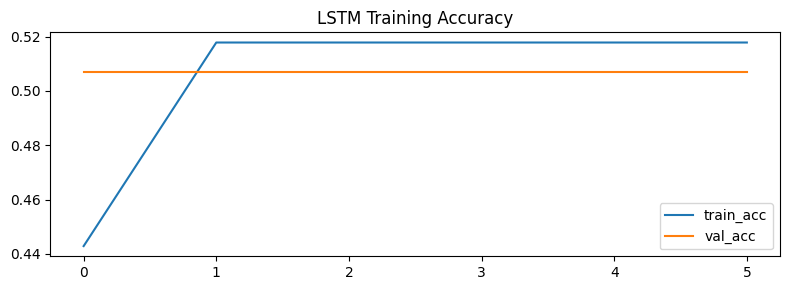

In [8]:
# Build sequence tensors for LSTM: using only Close for clarity
close = df['Close'].values
# Create sequences of length 30 and the next-day movement target
seq_len = 30

targets = (df['Close'].shift(-1) > df['Close']).astype(int).values
valid_idx = ~pd.isna(df['Close'].shift(seq_len)).values & ~pd.isna(df['Close'].shift(-1)).values

close_valid = close[valid_idx]
targets_valid = targets[valid_idx]

# Create (N, seq_len) sequences
X_seq = []
for i in range(seq_len, len(close_valid)):
    X_seq.append(close_valid[i-seq_len:i])
y_seq = targets_valid[seq_len:]

X_seq = np.array(X_seq).reshape(-1, seq_len, 1)  # features=1 (Close)
y_seq = np.array(y_seq)

# Train/test split (time-based)
split_idx_seq = int(len(X_seq)*0.8)
X_train_seq, X_test_seq = X_seq[:split_idx_seq], X_seq[split_idx_seq:]
y_train_seq, y_test_seq = y_seq[:split_idx_seq], y_seq[split_idx_seq:]

# Normalize per feature (fit on training only)
from sklearn.preprocessing import MinMaxScaler
scaler_seq = MinMaxScaler()
X_train_seq_2d = X_train_seq.reshape(-1, 1)
X_test_seq_2d  = X_test_seq.reshape(-1, 1)

X_train_seq_scaled = scaler_seq.fit_transform(X_train_seq_2d).reshape(X_train_seq.shape)
X_test_seq_scaled  = scaler_seq.transform(X_test_seq_2d).reshape(X_test_seq.shape)

# LSTM model
model = Sequential([
    LSTM(64, input_shape=(seq_len, 1)),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

es = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
history = model.fit(
    X_train_seq_scaled, y_train_seq,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[es],
    verbose=0
)

loss, acc = model.evaluate(X_test_seq_scaled, y_test_seq, verbose=0)
lstm_acc = acc
lstm_pred = (model.predict(X_test_seq_scaled, verbose=0).ravel() >= 0.5).astype(int)

lstm_prec = precision_score(y_test_seq, lstm_pred)
lstm_rec = recall_score(y_test_seq, lstm_pred)
print("LSTM — Acc:", lstm_acc, "Prec:", lstm_prec, "Rec:", lstm_rec)

# Optional: plot training curves
plt.figure(figsize=(8,3))
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('LSTM Training Accuracy'); plt.legend(); plt.tight_layout(); plt.show()


# Evaluation, comparison, and saving results


In [9]:
# Summary comparison
summary = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'LSTM'],
    'Accuracy': [lr_acc, rf_acc, lstm_acc],
    'Precision': [lr_prec, rf_prec, lstm_prec],
    'Recall': [lr_rec, rf_rec, lstm_rec]
})
print(summary)

# Save results
os.makedirs(RESULTS_PATH, exist_ok=True)
summary.to_csv(os.path.join(RESULTS_PATH, 'model_comparison.csv'), index=False)

                 Model  Accuracy  Precision    Recall
0  Logistic Regression  0.648936   0.682927  0.583333
1        Random Forest  0.659574   0.690476  0.604167
2                 LSTM  0.477273   0.000000  0.000000


# Model Evaluation Metrics Explained

This section explains the key metrics used to evaluate and compare machine learning models in the project.

## Accuracy
**Definition**: The proportion of total predictions that were correct.

**Formula**:
Accuracy = (True Positives + True Negatives) / Total Predictions


## Precision
**Definition**: The proportion of positive predictions that were actually correct.

**Formula**: Precision = True Positives / (True Positives + False Positives)

## Recall
**Definition**: The proportion of actual positives that were correctly identified.

**Formula**: Recall = True Positives / (True Positives + False Negatives)



---

## Summary
- **Accuracy** = overall correctness  
- **Precision** = how precise positive predictions are  
- **Recall** = how well positives are detected  

Use these metrics together to understand model performance from different angles — especially in imbalanced datasets.



# Model Performance Summary

## Logistic Regression
- **Accuracy**: 0.6489  
- **Precision**: 0.6829  
- **Recall**: 0.5833  

**Interpretation**:  
Logistic Regression performs reasonably well across all metrics. It has the highest precision, meaning it makes fewer false positive predictions. Its recall is moderate, indicating it captures a fair portion of actual positives. Overall, it’s a balanced baseline model.

---

## Random Forest
- **Accuracy**: 0.6596  
- **Precision**: 0.6905  
- **Recall**: 0.6042  

**Interpretation**:  
Random Forest slightly outperforms Logistic Regression in all metrics. It has the best overall accuracy and recall, suggesting it’s more effective at identifying true positives while maintaining precision. This makes it the strongest performer among the three.

---

## LSTM
- **Accuracy**: 0.4773  
- **Precision**: 0.0000  
- **Recall**: 0.0000  

**Interpretation**:  
The LSTM model underperforms significantly. It fails to correctly identify any positive cases, resulting in zero precision and recall. This suggests either the model wasn’t trained effectively, the data wasn’t suitable for LSTM, or hyperparameters need tuning.

---

## Summary
- **Best overall**: Random Forest  
- **Most balanced baseline**: Logistic Regression  
- **Needs improvement**: LSTM (likely due to data or configuration issues)
